In [1]:
!pip install datasets
!pip install jiwer

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 73.7 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.4 MB/s eta 0:00:00


In [4]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from jiwer import wer, cer
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchaudio.transforms as T
from torch.nn.utils.rnn import pad_sequence

In [2]:
# 경로 설정
# 샘플 데이터 경로
audio_dir = "/content/drive/MyDrive/mini_dataset/audio"
label_dir = "/content/drive/MyDrive/mini_dataset/label"

#경로 설정
# audio_dir = "/content/drive/MyDrive/public/dataset/audio"
# label_dir = "/content/drive/MyDrive/public/dataset/label"

In [5]:
# 1. Dataset 클래스 정의
class AudioDataset(Dataset):
    def __init__(self, audio_dir, label_dir, processor, target_sample_rate=16000):
        self.audio_dir = audio_dir
        self.label_dir = label_dir
        self.processor = processor
        self.target_sample_rate = target_sample_rate
        self.audio_files = [f for f in os.listdir(audio_dir) if f.endswith(".wav")]

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_file = self.audio_files[idx]
        label_file = audio_file.replace(".wav", ".txt")

        # 오디오 로드
        audio_path = os.path.join(self.audio_dir, audio_file)
        waveform, sr = load_audio(audio_path, self.target_sample_rate)

        # 레이블 로드
        label_path = os.path.join(self.label_dir, label_file)
        with open(label_path, 'r', encoding='utf-8') as f:
            label = f.read().strip()

        # 전처리 (Whisper 모델에 맞게)
        input_features = self.processor(waveform.numpy(), sampling_rate=self.target_sample_rate, return_tensors="pt").input_features
        return input_features.squeeze(), label

In [7]:

# 오디오 파일 로드 및 리샘플링
def load_audio(file_path, target_sample_rate=16000):
    waveform, sample_rate = torchaudio.load(file_path)

    # 샘플링 레이트가 16kHz가 아닌 경우 리샘플링
    if sample_rate != target_sample_rate:
        resampler = T.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)

    return waveform.squeeze(), target_sample_rate

# Custom Collate Function: 패딩을 추가하여 배치 내 입력 크기 통일
# def collate_fn(batch):
#     input_features = [item[0] for item in batch]  # 오디오 특징
#     labels = [item[1] for item in batch]  # 라벨 (텍스트)

#     # Whisper processor로 input_features를 패딩
#     input_features_padded = pad_sequence(input_features, batch_first=True)

#     # 라벨을 패딩
#     label_ids = processor.tokenizer(labels, return_tensors="pt", padding=True).input_ids

#     return input_features_padded, label_ids

# 2. 데이터셋 생성 및 95:5 비율로 학습/평가 데이터 분리
def create_dataloaders(audio_dir, label_dir, processor, batch_size=8, train_split=0.90):
    dataset = AudioDataset(audio_dir, label_dir, processor)
    train_size = int(len(dataset) * train_split)
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader

In [14]:
# 3. 모델 훈련 함수
def train(model, processor, train_loader, val_loader, num_epochs=5, device='cuda'):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

    # 각 Epoch별 손실 값 저장
    train_losses = []
    val_losses = []


    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training loop
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_loader):
            inputs, labels = batch
            inputs = inputs.to(device)

            # 레이블을 텍스트에서 토큰으로 변환
            label_ids = processor.tokenizer(labels, return_tensors="pt", padding=True).input_ids.to(device)

            # 모델 예측
            outputs = model(input_features=inputs, labels=label_ids)
            loss = outputs.loss
            total_train_loss += loss.item()

            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Training loss: {total_train_loss / len(train_loader)}")

        # Validation loop
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = inputs.to(device)

                # 레이블을 텍스트에서 토큰으로 변환
                label_ids = processor.tokenizer(labels, return_tensors="pt", padding=True).input_ids.to(device)

                # 모델 예측
                outputs = model(input_features=inputs, labels=label_ids)
                loss = outputs.loss
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Validation loss: {avg_val_loss:.4f}")

        # Evaluation loop
        evaluate(model, processor, val_loader, device)

    print("Training complete.")

    # Training and validation loss 그래프 그리기
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()




In [11]:

# 4. 평가 함수
def evaluate(model, processor, val_loader, device='cuda'):
    model.eval()
    predictions = []
    actuals = []

    # 한국어로 강제 설정 (language code for Korean is "<|ko|>")
    forced_decoder_ids = processor.tokenizer.convert_tokens_to_ids(["<|ko|>"])

    with torch.no_grad():
        for batch in tqdm(val_loader):
            inputs, labels = batch
            inputs = inputs.to(device)

            # 한국어로 강제 설정 (language code for Korean is "<|ko|>")
            # 1은 모델의 BOS (beginning of sentence) 토큰에 해당
            predicted_ids = model.generate(inputs, forced_decoder_ids=[[1, forced_decoder_ids[0]]])
            transcriptions = processor.batch_decode(predicted_ids, skip_special_tokens=True)

            predictions.extend(transcriptions)
            actuals.extend(labels)

    # WER, CER 계산
    wer_score = wer(actuals, predictions)
    cer_score = cer(actuals, predictions)
    print(f"WER: {wer_score}, CER: {cer_score}")

    return predictions, actuals

# 5. 성능 평가 시각화 및 예측 결과 출력
def plot_results(predictions, actuals):
    wer_scores = [wer([a], [p]) for a, p in zip(actuals, predictions)]
    cer_scores = [cer([a], [p]) for a, p in zip(actuals, predictions)]

    plt.figure(figsize=(10, 5))

    # WER 시각화
    plt.subplot(1, 2, 1)
    plt.hist(wer_scores, bins=10, alpha=0.75, color='blue')
    plt.title('Word Error Rate (WER)')
    plt.xlabel('WER')
    plt.ylabel('Frequency')

    # CER 시각화
    plt.subplot(1, 2, 2)
    plt.hist(cer_scores, bins=10, alpha=0.75, color='green')
    plt.title('Character Error Rate (CER)')
    plt.xlabel('CER')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    # 예측 결과 출력
    for i, (pred, act) in enumerate(zip(predictions, actuals)):
        print(f"예측 결과 {i + 1}:")
        print(f"  예측: {pred}")
        print(f"  실제: {act}")
        print("-" * 50)

# # 6. 전체 학습 및 평가 파이프라인 실행
# def run_pipeline(audio_dir, label_dir, batch_size=8, num_epochs=5):
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     # Whisper 모델과 프로세서 준비
#     processor = WhisperProcessor.from_pretrained("openai/whisper-small")
#     model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device)

#     # 데이터 로더 생성
#     train_loader, val_loader = create_dataloaders(audio_dir, label_dir, processor, batch_size=batch_size)

#     # 모델 훈련
#     train(model, processor, train_loader, val_loader, num_epochs=num_epochs, device=device)
#     print("Training complete.")

#     # 모델 평가 및 결과 시각화
#     predictions, actuals = evaluate(model, processor, val_loader, device=device)
#     plot_results(predictions, actuals)

# # 실행
# run_pipeline(audio_dir, label_dir)

Epoch 1/10


100%|██████████| 66/66 [10:53<00:00,  9.90s/it]


Training loss: 1.8688879184650653
Validation loss: 1.1226


100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


WER: 0.43636363636363634, CER: 0.27017543859649124
Epoch 2/10


100%|██████████| 66/66 [00:40<00:00,  1.65it/s]


Training loss: 0.8956731047594186
Validation loss: 0.8634


100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


WER: 0.4121212121212121, CER: 0.24912280701754386
Epoch 3/10


100%|██████████| 66/66 [00:40<00:00,  1.65it/s]


Training loss: 0.5346601887634306
Validation loss: 0.4899


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


WER: 0.3515151515151515, CER: 0.21929824561403508
Epoch 4/10


100%|██████████| 66/66 [00:40<00:00,  1.65it/s]


Training loss: 0.05045194353089866
Validation loss: 0.2724


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


WER: 0.3393939393939394, CER: 0.20877192982456141
Epoch 5/10


100%|██████████| 66/66 [00:40<00:00,  1.65it/s]


Training loss: 0.016258011840170984
Validation loss: 0.2589


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


WER: 0.3212121212121212, CER: 0.2
Epoch 6/10


100%|██████████| 66/66 [00:40<00:00,  1.64it/s]


Training loss: 0.010837821587990744
Validation loss: 0.2611


100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


WER: 0.32727272727272727, CER: 0.20701754385964913
Epoch 7/10


100%|██████████| 66/66 [00:40<00:00,  1.65it/s]


Training loss: 0.006336698402072106
Validation loss: 0.2599


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


WER: 0.3333333333333333, CER: 0.21228070175438596
Epoch 8/10


100%|██████████| 66/66 [00:40<00:00,  1.65it/s]


Training loss: 0.003432823278920048
Validation loss: 0.2604


100%|██████████| 8/8 [00:04<00:00,  1.62it/s]


WER: 0.3212121212121212, CER: 0.20350877192982456
Epoch 9/10


100%|██████████| 66/66 [00:40<00:00,  1.65it/s]


Training loss: 0.0031433996963173604
Validation loss: 0.2637


100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


WER: 0.3393939393939394, CER: 0.21052631578947367
Epoch 10/10


100%|██████████| 66/66 [00:40<00:00,  1.64it/s]


Training loss: 0.0021714945694177664
Validation loss: 0.2655


100%|██████████| 8/8 [00:04<00:00,  1.65it/s]


WER: 0.3212121212121212, CER: 0.20175438596491227
Training complete.


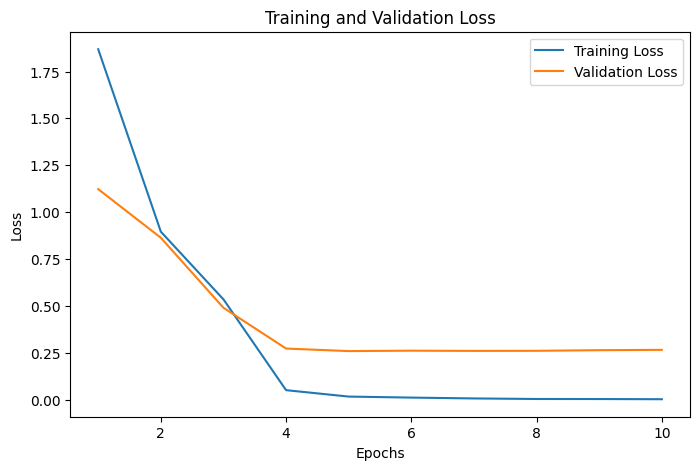

Training complete.


100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


WER: 0.3212121212121212, CER: 0.20175438596491227


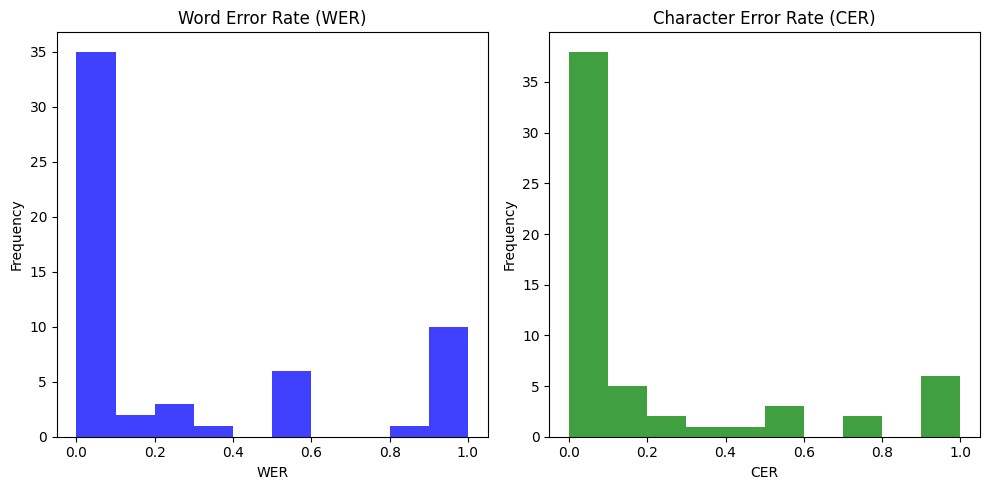

예측 결과 1:
  예측: 여기 놔요?
  실제: 여기 놔요?
--------------------------------------------------
예측 결과 2:
  예측: 등끝
  실제: 육군
--------------------------------------------------
예측 결과 3:
  예측: 아빠와 자동차를 타고 동물원에 갑니다.
  실제: 아빠와 자동차를 타고 동물원에 갑니다 잘 다녀와하면서 엄마가 뽀뽀를 해줍니다.
--------------------------------------------------
예측 결과 4:
  예측: 약국
  실제: 약국
--------------------------------------------------
예측 결과 5:
  예측: 그림이 보호회에 늘었습니다.
  실제: 그림은 못 두 개에 걸려 있습니다.
--------------------------------------------------
예측 결과 6:
  예측: 아들
  실제: 아들
--------------------------------------------------
예측 결과 7:
  예측: 나는 동물원 놀이터에서 그네를 탑니다.
  실제: 나는 동물원 놀이터에서 그네를 탑니다.
--------------------------------------------------
예측 결과 8:
  예측: 나비가 날아요.
  실제: 나비가 날아요.
--------------------------------------------------
예측 결과 9:
  예측: 땅콩
  실제: 땅콩
--------------------------------------------------
예측 결과 10:
  예측: 신발
  실제: 신발
--------------------------------------------------
예측 결과 11:
  예측: 동생
  실제: 동생
-------------------------------------------

In [15]:
# 6. 전체 학습 및 평가 파이프라인 실행
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Whisper 모델과 프로세서 준비
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device)

batch_size=8
num_epochs=10
# 데이터 로더 생성
train_loader, val_loader = create_dataloaders(audio_dir, label_dir, processor, batch_size=batch_size)

# 모델 훈련
train(model, processor, train_loader, val_loader, num_epochs=num_epochs, device=device)
print("Training complete.")

# 모델 평가 및 결과 시각화
predictions, actuals = evaluate(model, processor, val_loader, device=device)
plot_results(predictions, actuals)







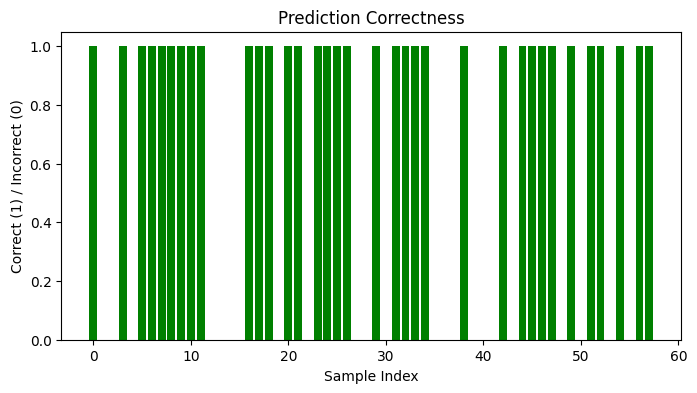

In [17]:
   # (4) 일치/불일치 정확도 그래프
correct = [1 if p == a else 0 for p, a in zip(predictions, actuals)]
plt.figure(figsize=(8, 4))
plt.bar(range(len(correct)), correct, color=['green' if x == 1 else 'red' for x in correct])
plt.title("Prediction Correctness")
plt.xlabel("Sample Index")
plt.ylabel("Correct (1) / Incorrect (0)")
plt.show()

In [18]:
wer_scores = [wer([a], [p]) for a, p in zip(actuals, predictions)]
cer_scores = [cer([a], [p]) for a, p in zip(actuals, predictions)]

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


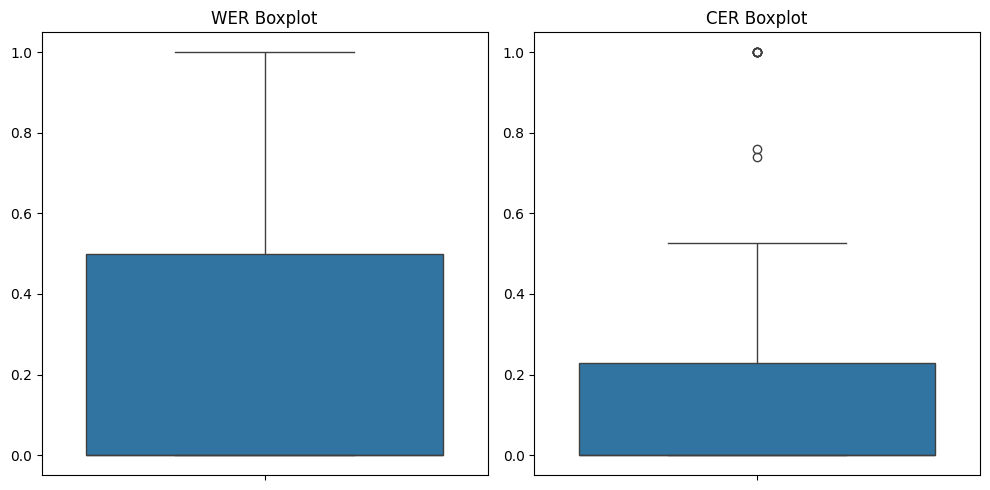

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
# (2) WER, CER Boxplot
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.boxplot(wer_scores)
plt.title('WER Boxplot')

plt.subplot(1, 2, 2)
sns.boxplot(cer_scores)
plt.title('CER Boxplot')

plt.tight_layout()
plt.show()

In [ ]:
    plt.figure(figsize=(10, 5))

    # WER 시각화
    plt.subplot(1, 2, 1)
    plt.hist(wer_scores, bins=10, alpha=0.75, color='blue')
    plt.title('Word Error Rate (WER)')
    plt.xlabel('WER')
    plt.ylabel('Frequency')

    # CER 시각화
    plt.subplot(1, 2, 2)
    plt.hist(cer_scores, bins=10, alpha=0.75, color='green')
    plt.title('Character Error Rate (CER)')
    plt.xlabel('CER')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()